# Initialization

In [ ]:
! git clone https://github.com/uber/causalml.git
% cd causalml
! pip install -r requirements-tf.txt
! pip install causalml[tf]
! pip install -U numpy	

In [14]:
# Import relevant Packages

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

from xgboost import XGBRegressor

from scipy.stats import norm, bernoulli
from scipy import random, stats

import causalml
from causalml.inference.meta import BaseXRegressor, BaseSRegressor, BaseTRegressor, BaseDRRegressor
from causalml.propensity import ElasticNetPropensityModel

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data Generation

In [15]:
# Function to generate scenario A-D

def data_gen(n=2000, d=10, seed = 388, effect = "complex", ran = False, balanced =True):
  # n: Number of Observations
  # d: Number of continuous Covariates
  # ran: Indicator for random assignment. If True, tan the propensity score is constant.
  # effect: Specify treatment effect function ["linear", "complex", "Null"]
  # balanced: Specify if dataset is balanced for a random assignment

  # set seed
  np.random.seed(seed)
  
  # create covariates 
  #--------------------------------------------
  X = np.random.normal(size=n*d).reshape((n, -1))

  #--------------------------------------------
  # Treatment effect
  if effect == "linear":
    tau = 2*X[:, 0] + 3*X[:,2]
  elif effect == "complex":
    tau = np.sin(X[:, 0]+0.5*X[:,2]+ 1/3*X[:, 9])+2*np.cos(X[:, 9])

  elif effect == "Null":
    tau = 0
  
  #--------------------------------------------
  # create Propensity Score
  if ran == False: # for non-random assignment
    alpha = X[:,2]+X[:,1]*X[:,7] - X[:,6]*X[:,9]
    alpha = e=norm.cdf(alpha)
  elif (ran == True) & (balanced == True): # for random balanced assignment
    e = np.repeat(0.5, n) 
  elif (ran == True) & (balanced == False): # for random inbalanced assignmet
    e = np.repeat(0.2, n) 

  #--------------------------------------------
  # Create binary treatment indicator
  treatment = np.random.binomial(n=1, p=e, size=n)

  #--------------------------------------------
  # Create Outcome
  y = tau*treatment + X[:,2]+X[:,1]*X[:,7]- X[:,6]*X[:,9] + np.random.normal(size=n) 
  
  #--------------------------------------------
  # Format data

  # Create dataframe with data
  data = pd.DataFrame({'treatment': treatment, 'outcome': y, 'ITE': tau, 'propensity':e})
  X = pd.DataFrame(X)
  data = pd.concat([data, X], axis = 1)
  
  # Change column names
  col =  ["treatment", "outcome", "ITE", "propensity"]
  for i in range(1,d+1):
    col.append("feature_"+str(i))
  data.columns = col
  
  return data

In [16]:
# Set parameters for data generation
N = 10000 # Number of Observations 
d= 10 # Number of Covariates
seed = 88 # Set seed

#--------------------------------------------
# Generate Scenario A-D
data_A = data_gen(n=N, d=d,effect = "complex", seed=seed, ran = True, balanced = True) # Scenario A
data_B= data_gen(n=N, d=d, effect = "complex", seed=seed,ran = True, balanced =False) # Scenario B
data_C = data_gen(n=N, d=d,seed=seed, ran = True, balanced = True, effect = "Null") # Scenario C
data_D = data_gen(n=14361, d=d, effect = "complex",seed=seed, ran = False) # Scenario D

#--------------------------------------------
# Remove observations with extreme propensity scores
data_D = data_D[data_D["propensity"]>0.05]
data_D = data_D[data_D["propensity"]<0.95]

#--------------------------------------------
# Store data
data = [data_A, data_B, data_C, data_D] 

# Deskriptive Analyse


In [18]:
# Get first impressions of the datasets
for dataset in data:
  print(dataset.describe())

          treatment       outcome  ...     feature_9    feature_10
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean       0.502000      0.647558  ...      0.003041      0.005180
std        0.500021      2.283918  ...      1.012418      0.995649
min        0.000000    -10.269676  ...     -3.611983     -3.544047
25%        0.000000     -0.832418  ...     -0.687982     -0.663972
50%        1.000000      0.641149  ...     -0.015698      0.010505
75%        1.000000      2.128886  ...      0.667482      0.668209
max        1.000000     10.942794  ...      3.948840      3.893566

[8 rows x 14 columns]
          treatment       outcome  ...     feature_9    feature_10
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean       0.211500      0.281989  ...      0.003041      0.005180
std        0.408392      2.147772  ...      1.012418      0.995649
min        0.000000     -9.189824  ...     -3.611983     -3.544047
25%        0.000000     -1.105420  ... 

In [19]:
# Group size and ATE in Scenario A-D
descriptive = pd.DataFrame()
for dataset in data:
  descriptive = descriptive.append({'Observations TG': dataset.query("treatment ==1").shape[0], 'Observations CG':dataset.query("treatment ==0").shape[0],'ATE':dataset.ITE.mean()}, ignore_index=True)

# Change index names
descriptive.index = ["Scenario A","Scenario B" ,"Scenario C", "Scenario D" ]
descriptive.round(4)

,Observations TG,Observations CG,ATE
Scenario A,5020.0,4980.0,1.2349
Scenario B,2115.0,7885.0,1.2349
Scenario C,5020.0,4980.0,0.0000
Scenario D,5001.0,4999.0,1.3363


Text(0, 0.5, '# of Samples')

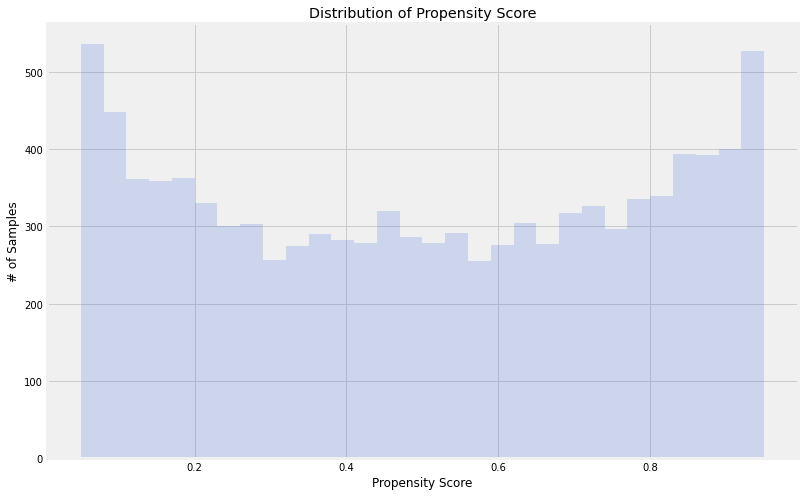

In [20]:
# Propensity Distribution for Scenario D
alpha=0.2
bins=30

#cate_xgb = cate_xgb_data1
plt.figure(figsize=(12,8)) 
plt.hist(data[3].propensity, alpha=alpha, bins=bins, label='true', color = "royalblue")
plt.title('Distribution of Propensity Score')
plt.xlabel('Propensity Score')
plt.ylabel('# of Samples')

Text(0, 0.5, '# of Samples')

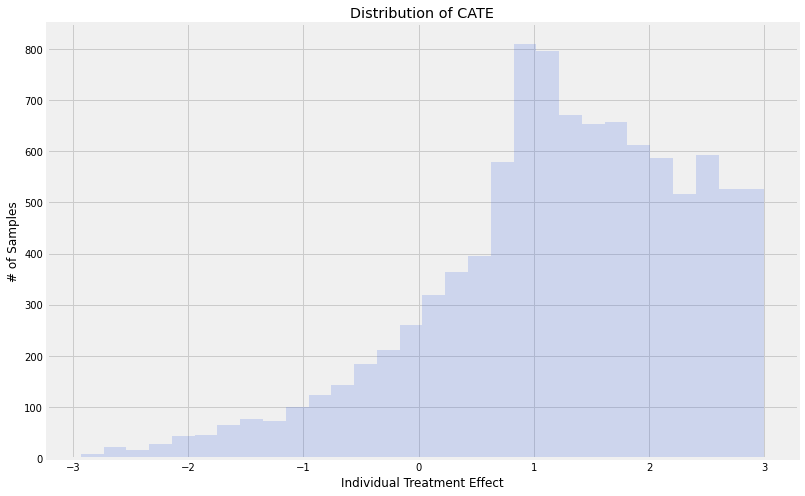

In [21]:
# Cate Distribution for Scenario A, B, D
alpha=0.2
bins=30

#cate_xgb = cate_xgb_data1
plt.figure(figsize=(12,8)) 
plt.hist(data[0].ITE, alpha=alpha, bins=bins, label='true', color = "royalblue")
plt.title('Distribution of CATE')
plt.xlabel('Individual Treatment Effect')
plt.ylabel('# of Samples')

Text(0, 0.5, '# of Samples')

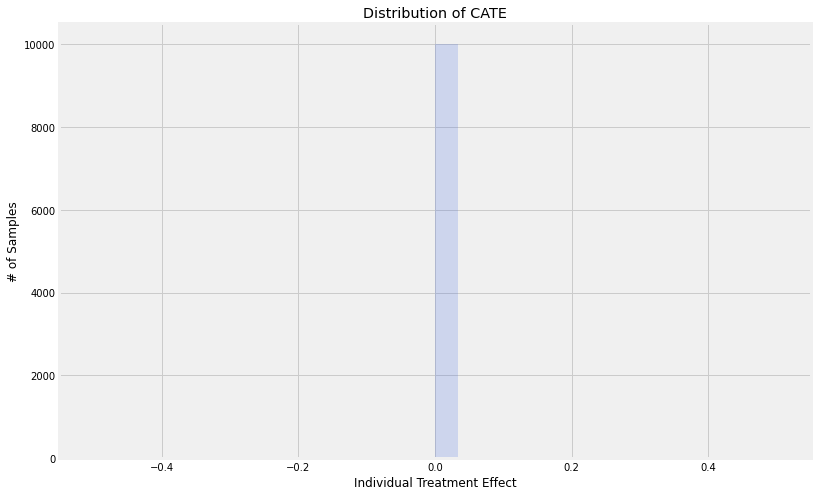

In [22]:
# Cate Distribution for Scenario C
alpha=0.2
bins=30

#cate_xgb = cate_xgb_data1
plt.figure(figsize=(12,8)) 
plt.hist(data[2].ITE, alpha=alpha, bins=bins, label='true', color = "royalblue")
plt.title('Distribution of CATE')
plt.xlabel('Individual Treatment Effect')
plt.ylabel('# of Samples')

# Initialize Models


In [23]:
# Base-Learner = Random Forest
#--------------------------------------------
rf = RandomForestRegressor(n_estimators = 200, random_state = 42) # Instantiate model with 200 decision trees
learner_s_rf = BaseSRegressor(rf)
learner_t_rf = BaseTRegressor(rf)
learner_x_rf = BaseXRegressor(rf)
learner_dr_rf = BaseDRRegressor(rf)

# Base-Learner = Extreme Gradient Boosting
#--------------------------------------------
learner_s_xgb = BaseSRegressor(XGBRegressor())
learner_t_xgb = BaseTRegressor(XGBRegressor())
learner_x_xgb = BaseXRegressor(XGBRegressor())
learner_dr_xgb = BaseDRRegressor(XGBRegressor())

# Store Models
#--------------------------------------------
models = [learner_s_rf, learner_t_rf, learner_x_rf, learner_dr_rf, learner_s_xgb, learner_t_xgb, learner_x_xgb, learner_dr_xgb] 

# Resubstitution Estiamte

## Cate Distribution

In [ ]:
# Get predictions for all datasets and all learners on the complete dataset (Resubstitution estimate)
cate_rf = pd.DataFrame()
cate_xgb = pd.DataFrame()
seed= 88

# For all datasets
#--------------------------------------------
for dataset in data:
  W = dataset['treatment']
  y = dataset['outcome']
  X = dataset.drop(['outcome','treatment','propensity','ITE'], axis=1)
  true_cate = dataset["ITE"]

  # S-Learner
  #--------------------------------------------
  # S-Learner with RF
  cate_s_rf = learner_s_rf.fit_predict(X=X, treatment=W, y=y)
  # S-Learner with XGB
  cate_s_xgb = learner_s_xgb.fit_predict(X=X, treatment=W, y=y)

  # T-Learner
  #--------------------------------------------
  # T-Learner with RF
  cate_t_rf = learner_t_rf.fit_predict(X=X, treatment=W, y=y)
  # T-Learner with XGB
  cate_t_xgb = learner_t_xgb.fit_predict(X=X, treatment=W, y=y)

  # X-Learner
  #--------------------------------------------
  # X-Learner with RF 
  cate_x_rf = learner_x_rf.fit_predict(X=X, treatment=W, y=y)
  # X-Learner with XGB
  cate_x_xgb = learner_x_xgb.fit_predict(X=X, treatment=W, y=y)

  # DR-Learner
  #--------------------------------------------
  # DR-Learner with RF
  cate_dr_rf = learner_dr_rf.fit_predict(X=X, treatment=W, y=y, seed = seed)
  # DR-Learner with XGB
  cate_dr_xgb = learner_dr_xgb.fit_predict(X=X, treatment=W, y=y, seed = seed)

  # Store estimations for every method and dataset
  #--------------------------------------------
  cate_rf = cate_rf.append({"S-Learner": cate_s_rf,"T-Learner": cate_t_rf,"X-Learner": cate_x_rf,"DR-Learner": cate_dr_rf }, ignore_index = True)
  cate_xgb = cate_xgb.append({"S-Learner": cate_s_xgb,"T-Learner": cate_t_xgb,"X-Learner": cate_x_xgb,"DR-Learner": cate_dr_xgb}, ignore_index = True)

#--------------------------------------------
# Change index names
ind = ["dataset_1"]
for i in range(2,len(data)+1):
  ind.append("dataset_"+str(i))
cate_rf.index = ind
cate_xgb.index = ind

Plots to visualize the distributions of the estimated CATEs.




Scenario A with XGB

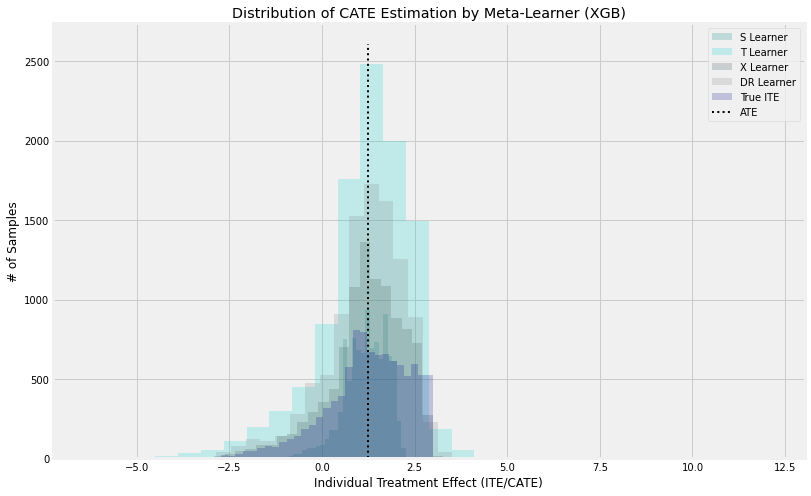

In [25]:
alpha=0.2
bins=30

#cate_xgb = cate_xgb_data1
plt.figure(figsize=(12,8)) # for dataset 2
plt.hist(cate_xgb.iloc[0,0], alpha=alpha, bins=bins, label='S Learner', color='teal')
plt.hist(cate_xgb.iloc[0,1], alpha=alpha, bins=bins, label='T Learner', color='darkturquoise')
plt.hist(cate_xgb.iloc[0,2], alpha=alpha, bins=bins, label='X Learner', color='darkslategrey')
plt.hist(cate_xgb.iloc[0,3], alpha=alpha, bins=bins, label='DR Learner', color='grey')
plt.hist(data[0].ITE, alpha=alpha, bins=bins, label='True ITE', color = "darkblue")
plt.vlines(data[0].ITE.mean(), 0, plt.axes().get_ylim()[1], label='ATE',
           linestyles='dotted', colors='black', linewidth=2)
plt.title('Distribution of CATE Estimation by Meta-Learner (XGB)')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

Scenario B with XGB

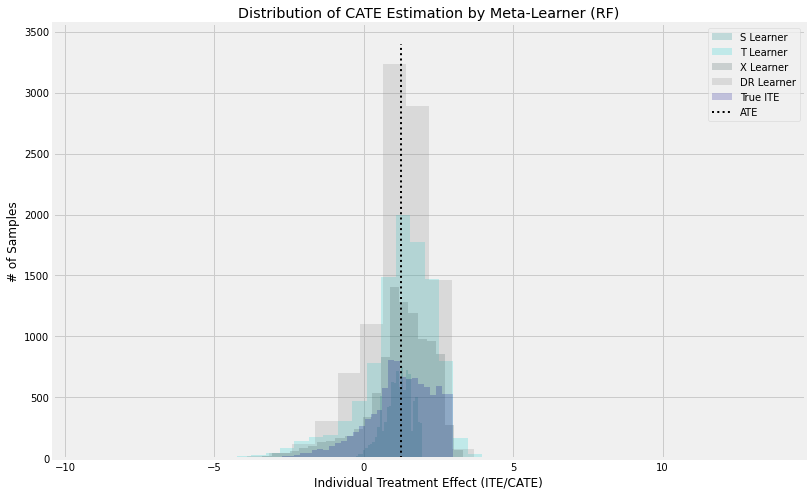

In [26]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(cate_xgb.iloc[1,0], alpha=alpha, bins=bins, label='S Learner', color='teal')
plt.hist(cate_xgb.iloc[1,1], alpha=alpha, bins=bins, label='T Learner', color='darkturquoise')
plt.hist(cate_xgb.iloc[1,2], alpha=alpha, bins=bins, label='X Learner', color='darkslategrey')
plt.hist(cate_xgb.iloc[1,3], alpha=alpha, bins=bins, label='DR Learner', color='grey')
plt.hist(data[1].ITE, alpha=alpha, bins=bins, label='True ITE', color = "darkblue")
plt.vlines(data[1].ITE.mean(), 0, plt.axes().get_ylim()[1], label='ATE',
           linestyles='dotted', colors='black', linewidth=2)
plt.title('Distribution of CATE Estimation by Meta-Learner (RF)')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

Scenario C with XGB

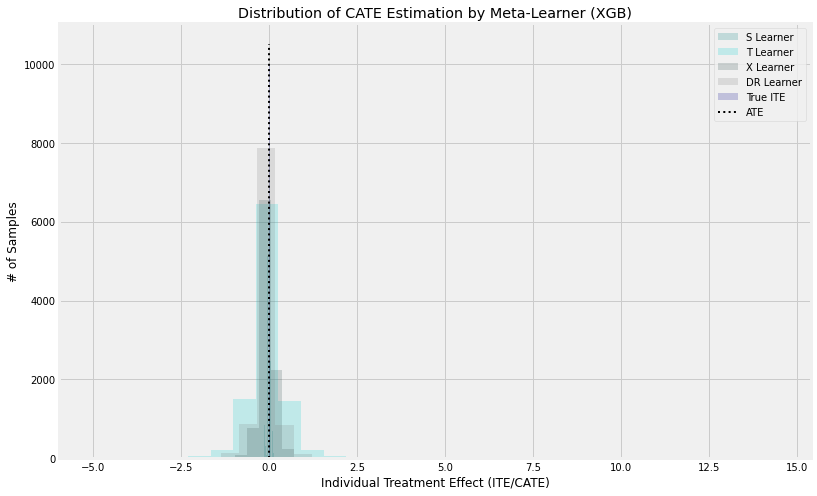

In [27]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(cate_xgb.iloc[2,0], alpha=alpha, bins=bins, label='S Learner', color='teal')
plt.hist(cate_xgb.iloc[2,1], alpha=alpha, bins=bins, label='T Learner', color='darkturquoise')
plt.hist(cate_xgb.iloc[2,2], alpha=alpha, bins=bins, label='X Learner', color='darkslategrey')
plt.hist(cate_xgb.iloc[2,3], alpha=alpha, bins=bins, label='DR Learner', color='grey')
plt.hist(data[2].ITE, alpha=alpha, bins=bins, label='True ITE', color = "darkblue")
plt.vlines(data[2].ITE.mean(), 0, plt.axes().get_ylim()[1], label='ATE',
           linestyles='dotted', colors='black', linewidth=2)
plt.title('Distribution of CATE Estimation by Meta-Learner (XGB)')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

Scenario D with XGB

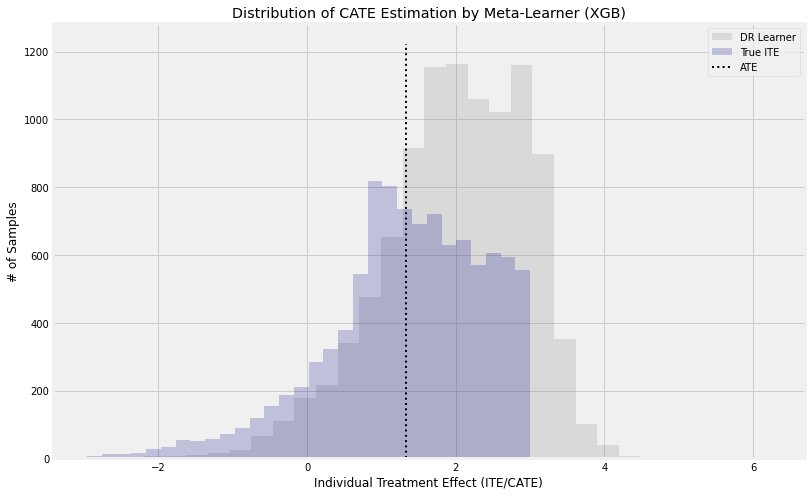

In [28]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))


#plt.hist(cate_xgb.iloc[3,0], alpha=alpha, bins=bins, label='S Learner', color='teal')
#plt.hist(cate_xgb.iloc[3,1], alpha=alpha, bins=bins, label='T Learner', color='darkturquoise')
#plt.hist(cate_xgb.iloc[3,2], alpha=alpha, bins=bins, label='X Learner', color='darkslategrey')
plt.hist(cate_xgb.iloc[3,3], alpha=alpha, bins=bins, label='DR Learner', color='grey')
plt.hist(data[3].ITE, alpha=alpha, bins=bins, label='True ITE', color = "darkblue")
plt.vlines(data[3].ITE.mean(), 0, plt.axes().get_ylim()[1], label='ATE',
           linestyles='dotted', colors='black', linewidth=2)
plt.title('Distribution of CATE Estimation by Meta-Learner (XGB)')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## True vs. Estimation ITE

Plots to visualize the accuracy and calculation of PEHE.

### Random Forest

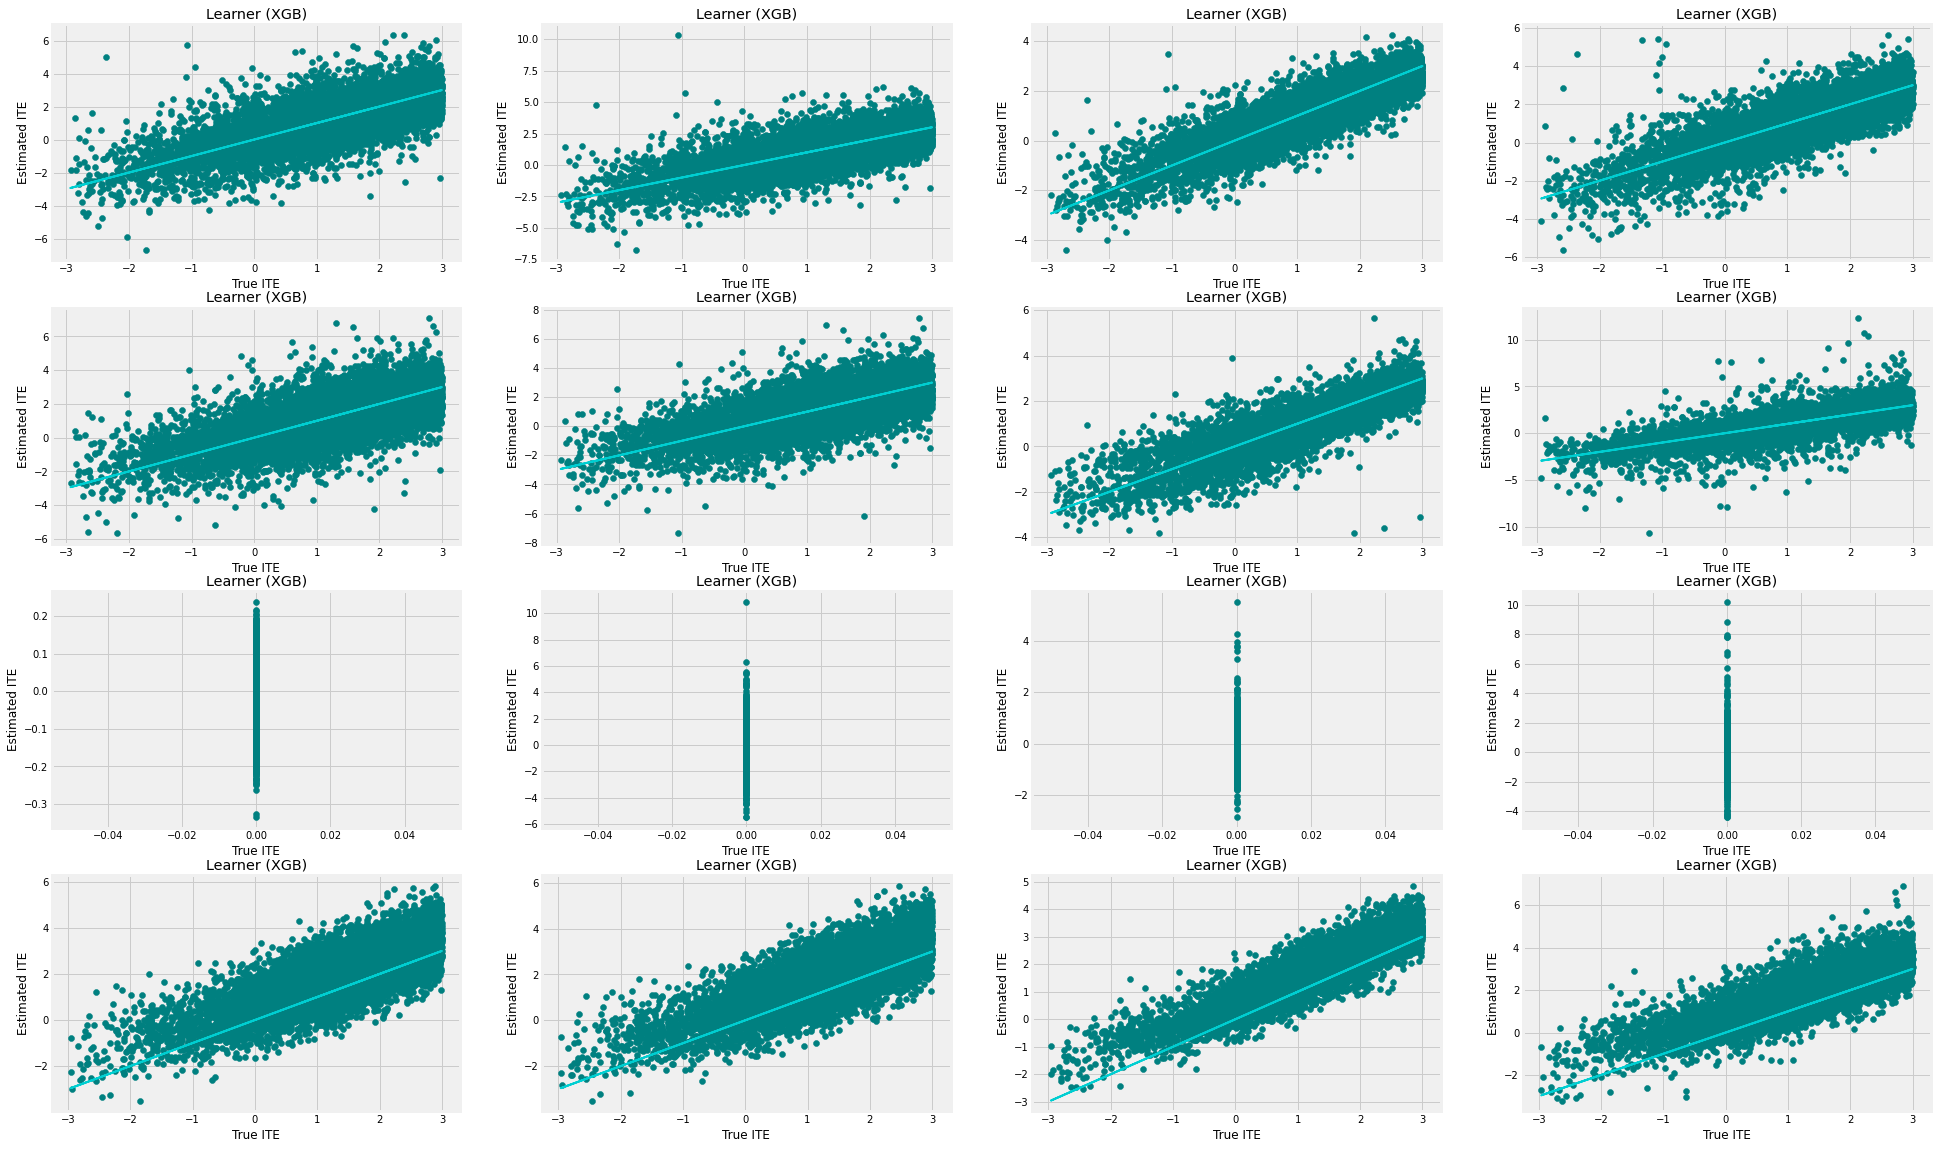

In [29]:
# Plot accuracy measures for RF 
fig, ax = plt.subplots(4,4, figsize=(30, 20))
i = 0
PEHE_rf = pd.DataFrame()
mask = pd.DataFrame()
k=0

# Get plots for every dataset (one dataset per row)
#--------------------------------------------
for dataset in data:
  true_cate = dataset["ITE"]
  dt = cate_rf.iloc[i,:]
  l = 0

  # For every Learner with RF
  #--------------------------------------------
  for set in dt:
    cate = set.reshape(len(set),)
    diff = (true_cate-cate)
    mask[l] = [np.square(diff).mean()] 

    ax[i,l].scatter(true_cate,set, color = 'teal')
    ax[i,l].plot(true_cate,true_cate, color='darkturquoise', linewidth=2)
    ax[i,l].set_xlabel('True ITE')
    ax[i,l].set_ylabel('Estimated ITE')
    ax[i,l].set_title('Learner (XGB)')
    if l == (len(dt)-1): # for last learner
      PEHE_rf = PEHE_rf.append(mask) # store mse for dataset k 
    l = l + 1

  i = i + 1

# Adjust Dataframe
#--------------------------------------------
# change index names
PEHE_rf.index = ["Scenario A","Scenario B", "Scenario C", "Scenario D"]

# rename columns
PEHE_rf = PEHE_rf.rename(columns={0: 'S-Learner',1: 'T-Learner',2: 'X-Learner',3: 'DR-Learner', })

# Transpse dataframe
PEHE_rf = PEHE_rf.transpose()


In [30]:
# show pehe for rf
PEHE_rf.round(4)

,Scenario A,Scenario B,Scenario C,Scenario D
S-Learner,1.0005,1.1042,0.0038,0.9556
T-Learner,1.0369,1.1303,0.9244,0.9530
X-Learner,0.3172,0.3335,0.2018,0.4774
DR-Learner,0.6144,1.0058,0.5722,0.8148


### XGB

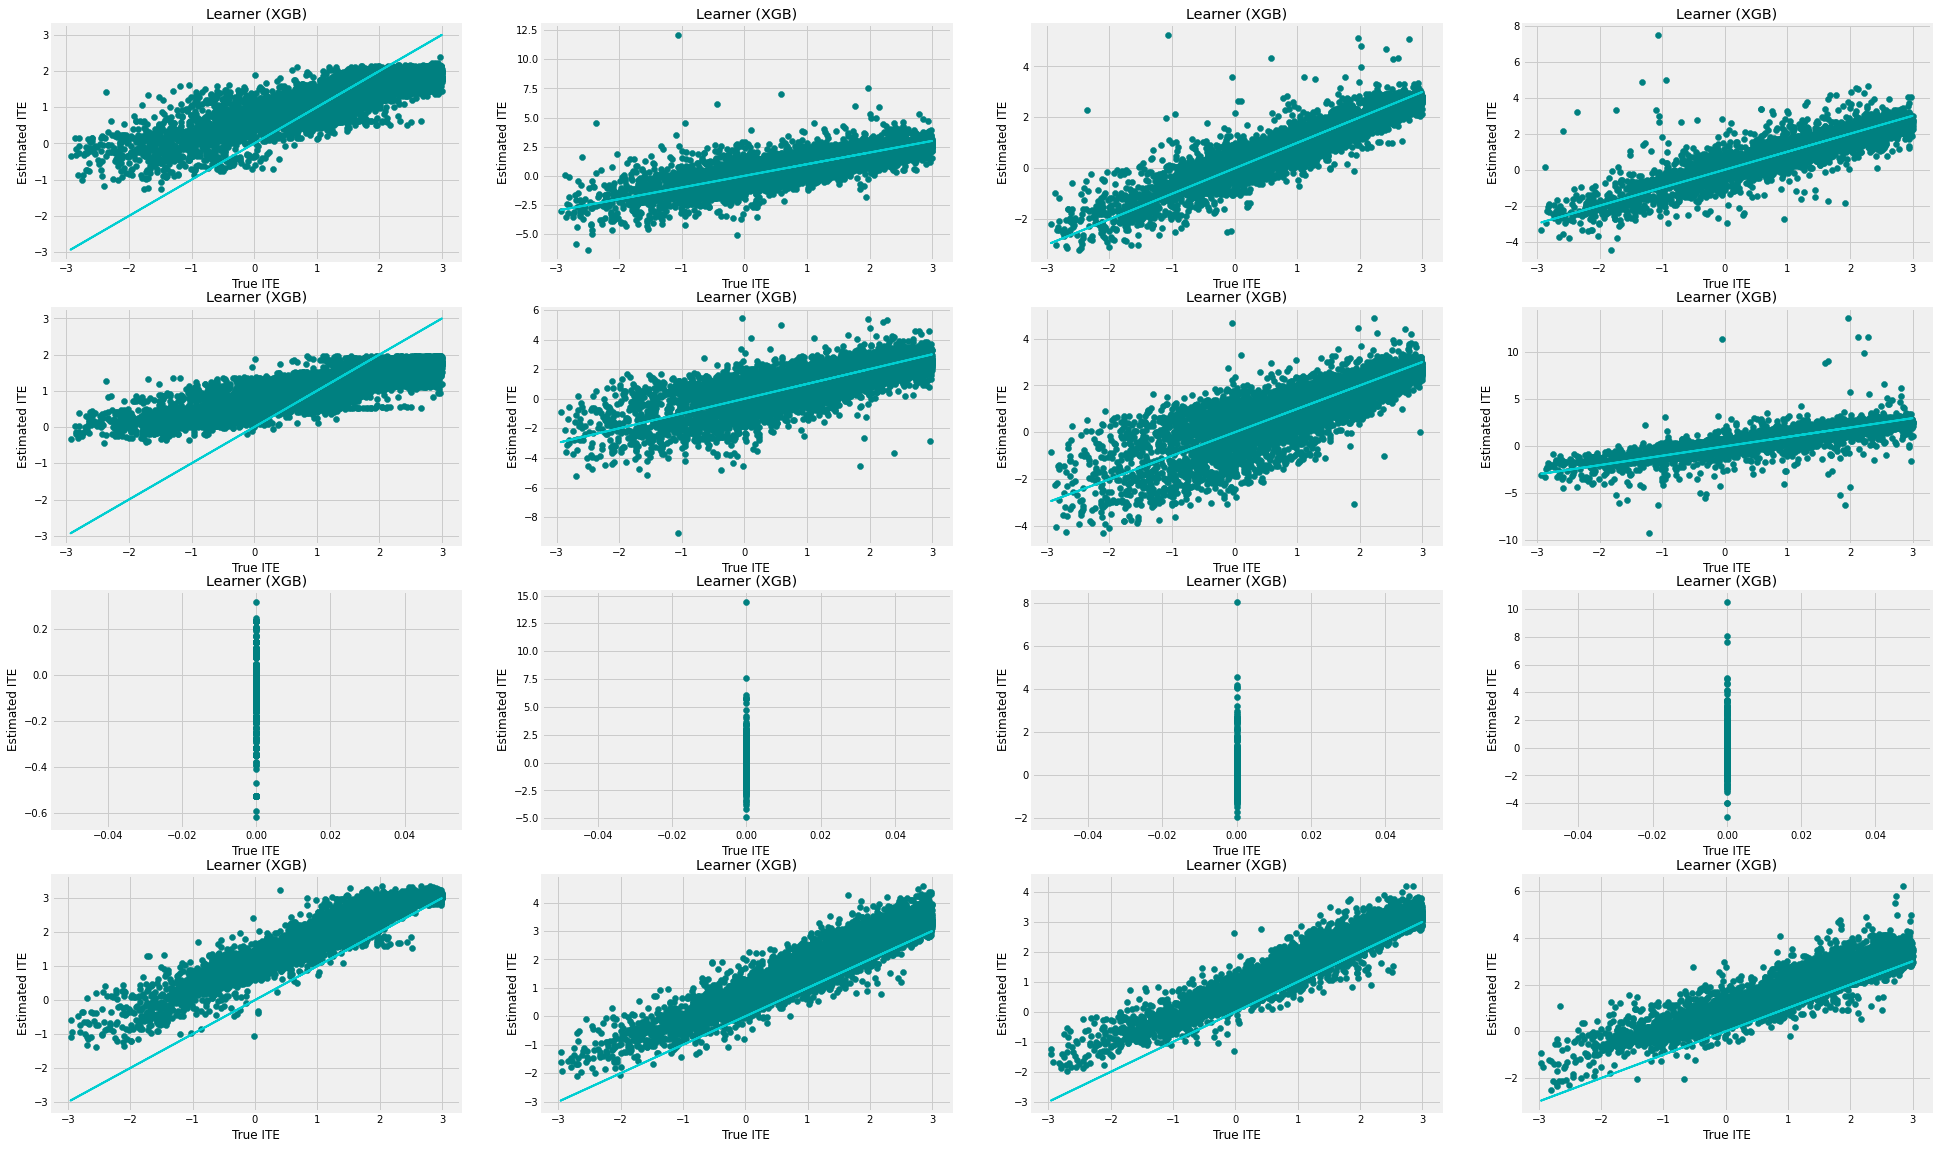

In [31]:
# Plot accuracy measures for XGB

fig, ax = plt.subplots(4,4, figsize=(30, 20))
i = 0
PEHE_xgb = pd.DataFrame()
mask = pd.DataFrame()
k=0

# Get plots for every dataset (one dataset per row)
#--------------------------------------------
for dataset in data:
  true_cate = dataset["ITE"]
  dt = cate_xgb.iloc[i,:]
  l = 0

  # For every Learner with RF
  #--------------------------------------------
  for set in dt:
    cate = set.reshape(len(set),)
    diff = (true_cate-cate)
    mask[l] = [np.square(diff).mean()] 

    ax[i,l].scatter(true_cate,set, color = 'teal')
    ax[i,l].plot(true_cate,true_cate, color='darkturquoise', linewidth=2)
    ax[i,l].set_xlabel('True ITE')
    ax[i,l].set_ylabel('Estimated ITE')
    ax[i,l].set_title('Learner (XGB)')
    if l == (len(dt)-1): # for last learner
      PEHE_xgb = PEHE_xgb.append(mask) # store mse for dataset k 
    l = l + 1

  i = i + 1
  
# Adjust Dataframe
#--------------------------------------------
# change index names
PEHE_xgb.index = ["Scenario A","Scenario B", "Scenario C", "Scenario D"]

# rename columns
PEHE_xgb = PEHE_xgb.rename(columns={0: 'S-Learner',1: 'T-Learner',2: 'X-Learner',3: 'DR-Learner', })

# Transpse dataframe
PEHE_xgb = PEHE_xgb.transpose()


In [32]:
# show pehe for xgb
PEHE_xgb.round(4)

,Scenario A,Scenario B,Scenario C,Scenario D
S-Learner,0.5053,0.6389,0.0053,0.7000
T-Learner,0.4732,0.6135,0.3025,0.5556
X-Learner,0.1629,0.4068,0.0794,0.3955
DR-Learner,0.2278,0.3602,0.1768,0.6177


# Cross-Validation 








In [ ]:
# Get accuracy measures for all learners in all datasets

Accuracy = pd.DataFrame() # Create Dataframe to store the calculated metrics
seed = 88 # Set seed
k = 5 # Define number of splits

# Loops through the data list
# ----------------------------------------------------------------
for dataset in data:
  def cv_split(seq, splits):
    return (seq[i::splits] for i in range(splits)) 
  
  # Split the data into k folds 
  cv_split_list = list(cv_split(shuffle(dataset.index.values.tolist(), random_state = seed), k)) 

  W = dataset['treatment']
  y = dataset['outcome']
  X = dataset.drop(['outcome','treatment','propensity','ITE'], axis=1)
  true_cate = dataset["ITE"]

  # Loops through the model list
  # ----------------------------------------------------------------
  for x, model in enumerate(models):
  
    # Empty variable needed for the loop
    PEHE = pd.DataFrame()
    BIAS = pd.DataFrame()

    # Start another loop for the cv_split_split, every model will go through this loop
    # ----------------------------------------------------------------
    for i, cv_split in enumerate(cv_split_list): 

      # Apply cv_split to the data frame, matches indeces in cv_split and the whole dataframe and creates a variable including the subset
      test_index = dataset.index.isin(cv_split)  # cv_split defines our hold out data for each round           
                       
      # Split data using the test_index variable                                    
      X_train, y_train, W_train, true_cate_train = X.loc[~test_index], y[~test_index], W[~test_index], true_cate[~test_index]
      X_test, y_test, W_test, true_cate_test = X.loc[test_index], y[test_index], W[test_index], true_cate[test_index]

      # Fit model to training data 
      if (x == 3) | (x == 7):# for DR-Learner
        model.fit(X=X_train, treatment=W_train, y=y_train, seed = seed)
      else:
        model.fit(X=X_train, treatment=W_train, y=y_train)

      # Predict on test data
      cate = model.predict(X=X_test, treatment=W_test)
      cate = cate.reshape(len(cate),) # reshape for calculation

      # Calculate MSE or PEHE for Fold i
      PEHE[i] = [(np.square(np.subtract(cate,true_cate_test))).mean()]

      # Calculate absolute Bias
      BIAS[i]= [(abs(cate-true_cate_test)).mean()]

      # Store data for calculating standard deviation
      if i == 0:
        cate_0 = cate
      elif i == 1:
        cate_1 = cate
      elif i == 2:
        cate_2 = cate
      elif i ==3:
        cate_3 = cate
      else:
        cate_4 = cate

     # For the final iteration:
     # ----------------------------------------------------------------
      if i == (k-1): 
      
        pehe = PEHE.mean(axis = 1) # Average accuracy measure over all folds
        bias = BIAS.mean(axis = 1) # Average accuracy measure over all folds

        # Calculate average cate estimation
        cate_hat_mean = np.mean([cate_0, cate_1, cate_2, cate_3], axis=0)

        # Calculate standard deviation
        a = np.sqrt((np.square(cate_0 - cate_hat_mean)).mean())
        b = np.sqrt((np.square(cate_1 - cate_hat_mean)).mean())
        c = np.sqrt((np.square(cate_2 - cate_hat_mean)).mean())
        d = np.sqrt((np.square(cate_3 - cate_hat_mean)).mean())
        e = np.sqrt((np.square(cate_4 - cate_hat_mean)).mean())
        sd = [a,b,c,d,e]
        sd = np.mean(sd)   
        
        #Add measures for model "model" to the dataframe
        Accuracy = Accuracy.append({'PEHE': pehe[0], 'BIAS':bias[0], 'SD': sd}, ignore_index=True)


# Add index names
# ----------------------------------------------------------------
ind = ["model_1"]
for i in range(2,len(models)*len(data)+1):
  ind.append("model_"+str(i))
Accuracy.index = ind

In [34]:
# Change index names
Accuracy.index = ["S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB" ]

# Split the dataframe for every scenario
accuracy_A = Accuracy.iloc[0:8,:] # accuracy metrics for scenario A
accuracy_B = Accuracy.iloc[8:16,:] # accuracy metrics for scenario B
accuracy_C = Accuracy.iloc[16:24,:] # accuracy metrics for scenario C
accuracy_D = Accuracy.iloc[24:32,:] # accuracy metrics for scenario D

# Store accuracy metrices
accuracy = [accuracy_A, accuracy_B, accuracy_C, accuracy_D]

In [35]:
# Show accuracy metrics for scenario A
accuracy_A.round(4)

,PEHE,BIAS,SD
S-Learner_rf,0.5029,0.5104,1.0961
T-Learner_rf,0.5415,0.5238,1.1240
X-Learner_rf,0.1883,0.3172,0.9781
DR-Learner_rf,0.2603,0.3723,1.0722
S-Learner_XGB,0.5173,0.5727,0.5327
T-Learner_XGB,0.5242,0.4915,1.1336
X-Learner_XGB,0.1749,0.3011,0.9572
DR-Learner_XGB,0.2257,0.3341,0.9738


In [36]:
# Show accuracy metrics for scenario B
accuracy_B.round(4)

,PEHE,BIAS,SD
S-Learner_rf,0.5229,0.5472,1.0401
T-Learner_rf,0.5546,0.5566,1.0833
X-Learner_rf,0.2596,0.3679,1.0063
DR-Learner_rf,0.5350,0.4901,1.1971
S-Learner_XGB,0.7263,0.6770,0.3948
T-Learner_XGB,0.6177,0.5709,1.1324
X-Learner_XGB,0.3971,0.4382,1.0503
DR-Learner_XGB,0.3551,0.3884,1.0209


In [37]:
# Show accuracy metrics for scenario C
accuracy_C.round(4)

,PEHE,BIAS,SD
S-Learner_rf,0.0022,0.0353,0.0414
T-Learner_rf,0.3094,0.3913,0.5066
X-Learner_rf,0.0757,0.1903,0.2444
DR-Learner_rf,0.1737,0.2829,0.3747
S-Learner_XGB,0.0053,0.0402,0.0638
T-Learner_XGB,0.3006,0.3638,0.4993
X-Learner_XGB,0.0708,0.1698,0.2383
DR-Learner_XGB,0.1456,0.2223,0.3409


In [38]:
# Show accuracy metrics for scenario D
accuracy_D.round(4)

,PEHE,BIAS,SD
S-Learner_rf,0.5990,0.6442,0.9913
T-Learner_rf,0.5938,0.6412,0.9891
X-Learner_rf,0.4168,0.5531,0.9270
DR-Learner_rf,0.6132,0.6663,0.9330
S-Learner_XGB,0.7248,0.7451,0.7045
T-Learner_XGB,0.5650,0.6634,0.9455
X-Learner_XGB,0.4128,0.5671,0.8883
DR-Learner_XGB,0.6257,0.6805,0.8735


The following code has been added to visualize the accuracy metrics. The first column shows the mean absolute bias, the second the mean PEHE and the third one the mean standard deviation. The differnet scenarios can be found in  the diffent rows. (One Scenario per row from A to D)

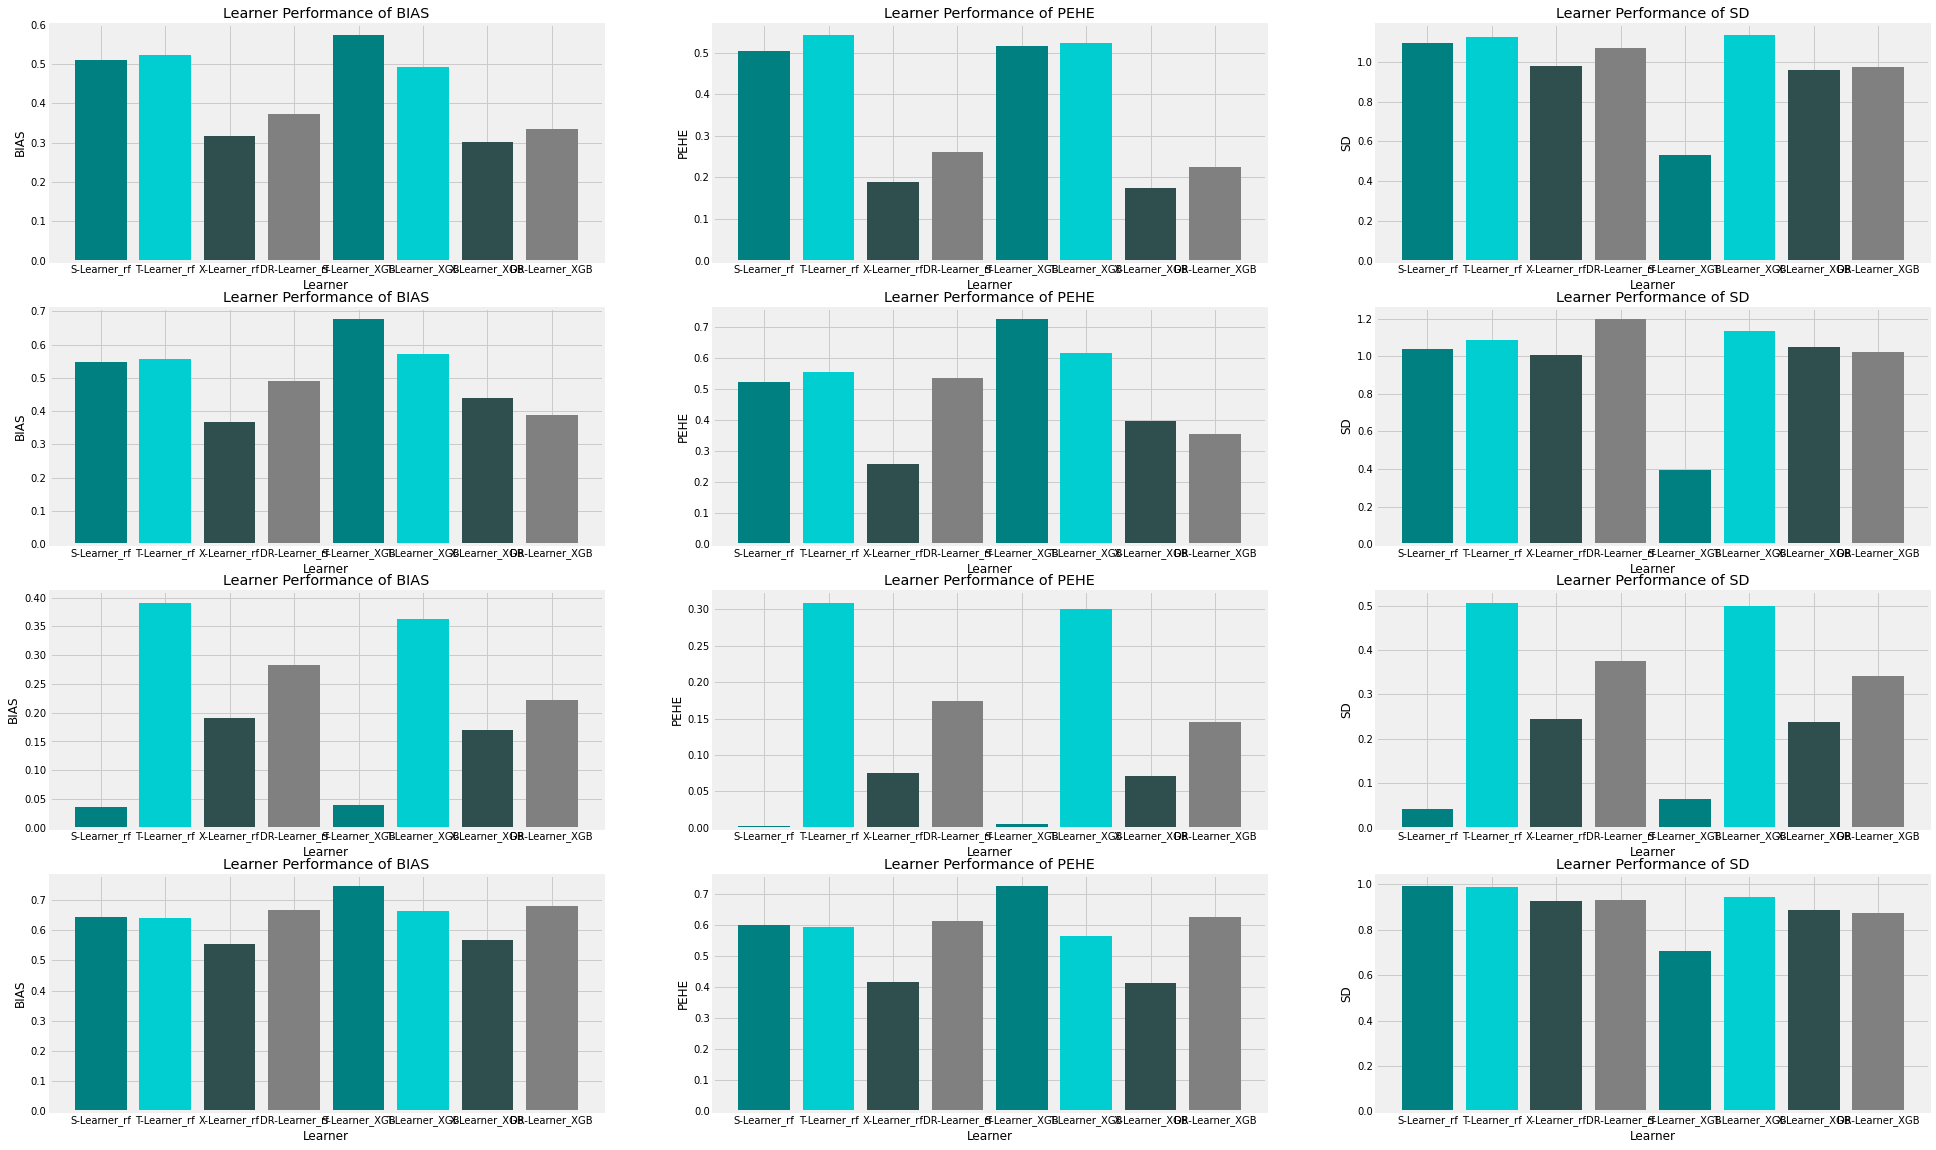

In [39]:
fig, ax = plt.subplots(4,3, figsize=(30, 20))
# Plot accuracy measures
i = 0

# Get plots for every dataset (one dataset per row)
# ----------------------------------------------------------------
for dataset in accuracy:

  # BIAS
  # ----------------------------------------------------------------
  ax[i,0].bar(dataset.index, height= dataset["BIAS"], color=['teal', 'darkturquoise', 'darkslategrey', 'grey', 'teal', 'darkturquoise', 'darkslategrey', 'grey'])
  ax[i,0].set_title('Learner Performance of BIAS')
  ax[i,0].set_xlabel('Learner')
  ax[i,0].set_ylabel('BIAS')
  
  # PEHE
  # ----------------------------------------------------------------
  ax[i,1].bar(dataset.index, height= dataset["PEHE"], color=['teal', 'darkturquoise', 'darkslategrey', 'grey', 'teal', 'darkturquoise', 'darkslategrey', 'grey'])
  ax[i,1].set_title('Learner Performance of PEHE')
  ax[i,1].set_xlabel('Learner')
  ax[i,1].set_ylabel('PEHE')
  
  # SD
  # ----------------------------------------------------------------
  ax[i,2].bar(dataset.index, height= dataset["SD"], color=['teal', 'darkturquoise', 'darkslategrey', 'grey', 'teal', 'darkturquoise', 'darkslategrey', 'grey'])
  ax[i,2].set_title('Learner Performance of SD')
  ax[i,2].set_xlabel('Learner')
  ax[i,2].set_ylabel('SD')

  i = i+1

# Split-Sample Approach

In [ ]:
# Get accuracy measures for all learners in all datasets

Accuracy = pd.DataFrame() # Create Dataframe to store the calculated metrics
seed = 88 # Set seed

# Loops through the data list
# ----------------------------------------------------------------
for dataset in data:
  
  # Split the data 
  train, test = train_test_split(dataset, test_size= 0.2, random_state = seed)

  # Loops through the model list
  # ----------------------------------------------------------------
  for x, model in enumerate(models):
  
    # Empty variable needed for the loop
    PEHE = pd.DataFrame()
    BIAS = pd.DataFrame()         
                       
    # Split data using the test_index variable                                    
    X_train = train.drop(['outcome','treatment','propensity','ITE'], axis=1)
    y_train =train['outcome']
    W_train =train['treatment']
    tue_cate_train =train["ITE"]
    X_test=test.drop(['outcome','treatment','propensity','ITE'], axis=1)
    y_test=test['outcome']
    W_test=test['treatment']
    true_cate_test=test["ITE"]

    # Fit model to training data 
    if (x == 3) | (x == 7):# for DR-Learner
      model.fit(X=X_train, treatment=W_train, y=y_train, seed = seed)
    else:
      model.fit(X=X_train, treatment=W_train, y=y_train)

    # Predict on test data
    cate = model.predict(X=X_test, treatment=W_test)
    cate = cate.reshape(len(cate),) # reshape for calculation

    # Calculate MSE or PEHE for Fold i
    pehe = [(np.square(np.subtract(cate,true_cate_test))).mean()]

    # Calculate absolute Bias
    bias= [(abs(cate-true_cate_test)).mean()]
    
    #Add measures for model "model" to the dataframe
    Accuracy = Accuracy.append({'PEHE': pehe[0], 'BIAS':bias[0]}, ignore_index=True)


# Add index names
# ----------------------------------------------------------------
ind = ["model_1"]
for i in range(2,len(models)*len(data)+1):
  ind.append("model_"+str(i))
Accuracy.index = ind

In [41]:
# Change index names
Accuracy.index = ["S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB", "S-Learner_rf","T-Learner_rf","X-Learner_rf","DR-Learner_rf","S-Learner_XGB","T-Learner_XGB","X-Learner_XGB","DR-Learner_XGB" ]

# Split the dataframe for every scenario
accuracy_A = Accuracy.iloc[0:8,:] # accuracy metrics for scenario A
accuracy_B = Accuracy.iloc[8:16,:] # accuracy metrics for scenario B
accuracy_C = Accuracy.iloc[16:24,:] # accuracy metrics for scenario C
accuracy_D = Accuracy.iloc[24:32,:] # accuracy metrics for scenario D

# Store accuracy metrices
accuracy = [accuracy_A, accuracy_B, accuracy_C, accuracy_D]

In [42]:
# Show accuracy metrics for scenario A
accuracy_A.round(4)

,PEHE,BIAS
S-Learner_rf,0.5209,0.5138
T-Learner_rf,0.5487,0.5233
X-Learner_rf,0.2021,0.3241
DR-Learner_rf,0.2553,0.3698
S-Learner_XGB,0.4840,0.5404
T-Learner_XGB,0.5079,0.5093
X-Learner_XGB,0.1722,0.3003
DR-Learner_XGB,0.1969,0.3203


In [43]:
# Show accuracy metrics for scenario B
accuracy_B.round(4)

,PEHE,BIAS
S-Learner_rf,0.5328,0.5513
T-Learner_rf,0.5774,0.5705
X-Learner_rf,0.2622,0.3715
DR-Learner_rf,0.4466,0.4658
S-Learner_XGB,0.7424,0.6826
T-Learner_XGB,0.5573,0.5569
X-Learner_XGB,0.3369,0.4206
DR-Learner_XGB,0.2858,0.3772


In [44]:
# Show accuracy metrics for scenario C
accuracy_C.round(4)

,PEHE,BIAS
S-Learner_rf,0.0022,0.0357
T-Learner_rf,0.3146,0.3947
X-Learner_rf,0.0593,0.1720
DR-Learner_rf,0.1624,0.2831
S-Learner_XGB,0.0001,0.0073
T-Learner_XGB,0.2655,0.3421
X-Learner_XGB,0.0712,0.1694
DR-Learner_XGB,0.1380,0.2271


In [45]:
# Show accuracy metrics for scenario D
accuracy_D.round(4)

,PEHE,BIAS
S-Learner_rf,0.5870,0.6306
T-Learner_rf,0.5771,0.6253
X-Learner_rf,0.4052,0.5331
DR-Learner_rf,0.6134,0.6567
S-Learner_XGB,0.7136,0.7315
T-Learner_XGB,0.5974,0.6743
X-Learner_XGB,0.4524,0.5827
DR-Learner_XGB,0.6566,0.6782


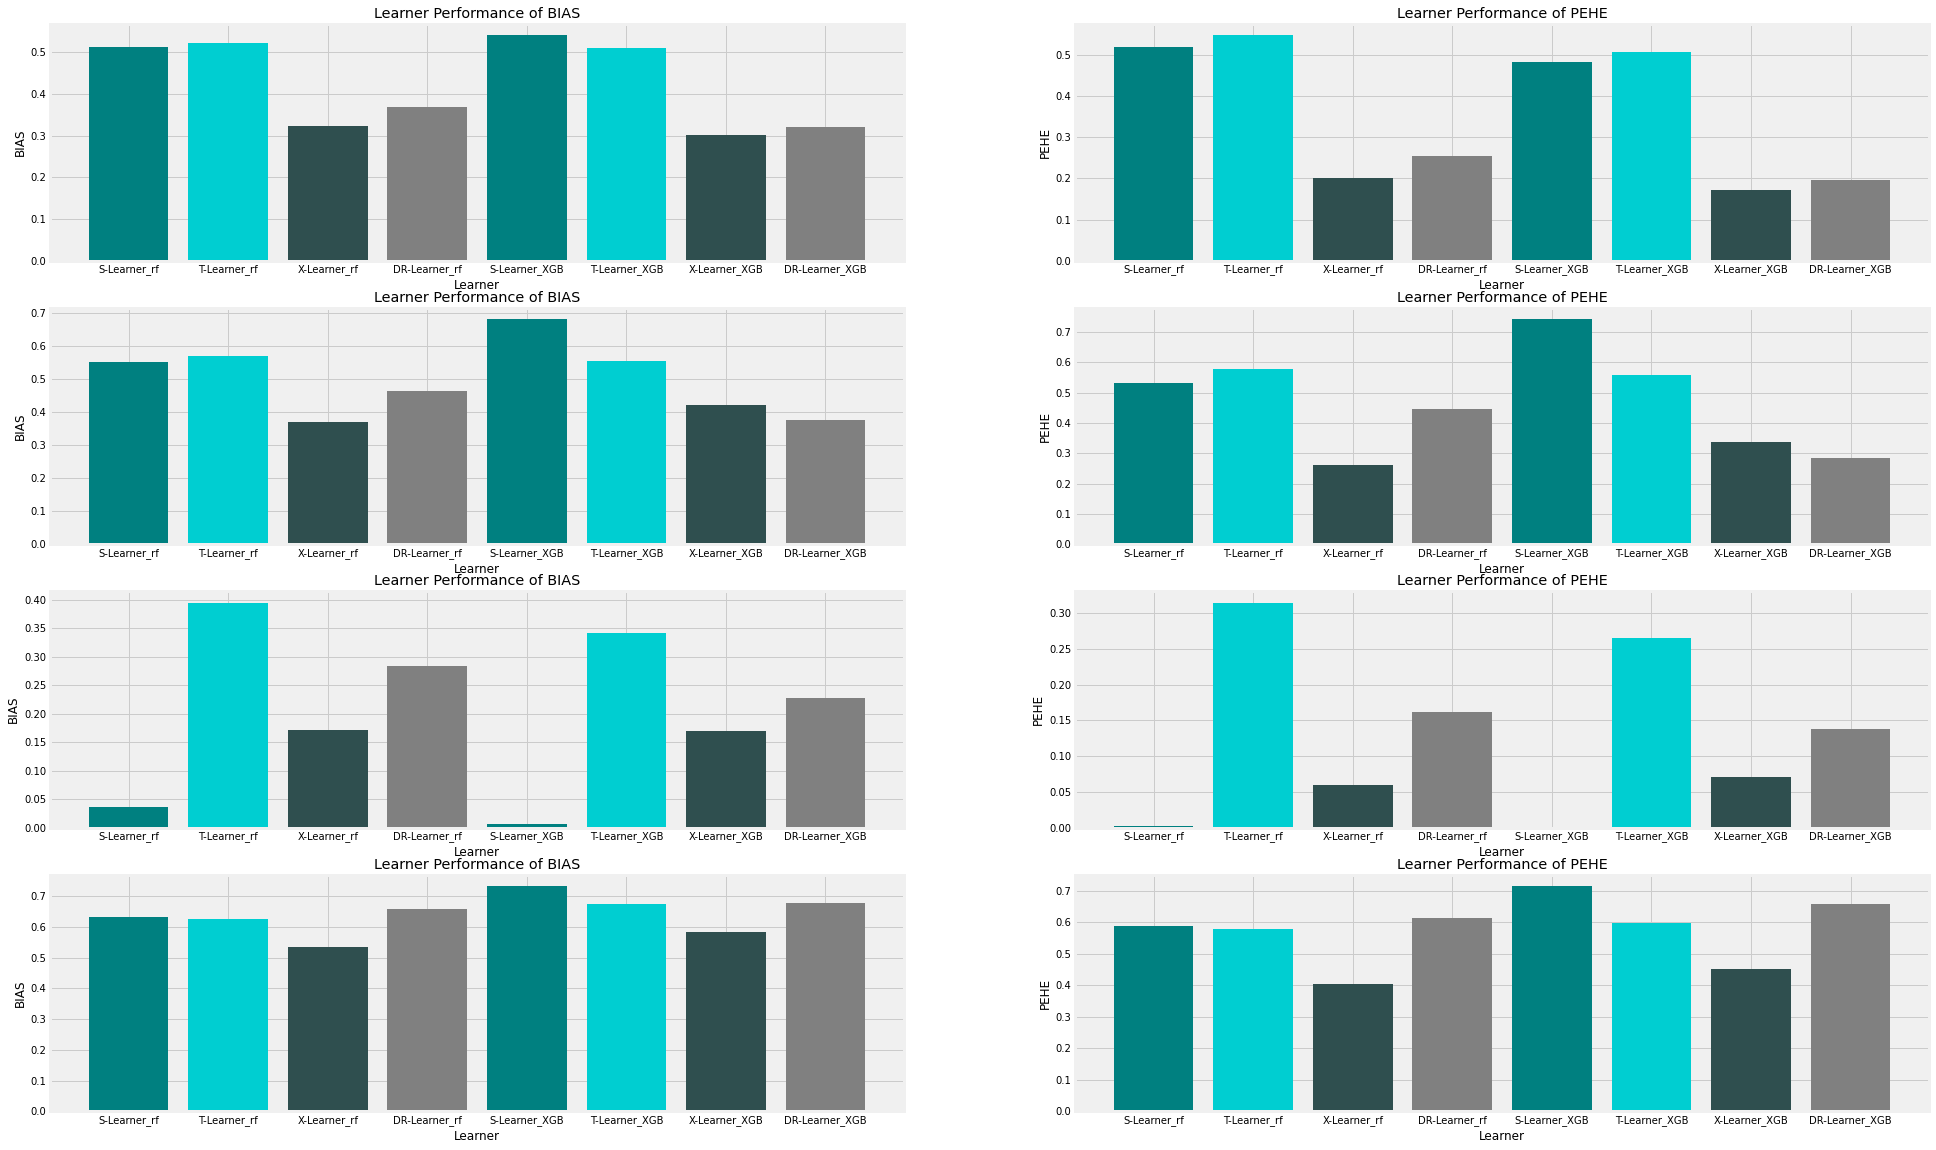

In [46]:
fig, ax = plt.subplots(4,2, figsize=(30, 20))
# Plot accuracy measures
i = 0

# Get plots for every dataset (one dataset per row)
# ----------------------------------------------------------------
for dataset in accuracy:

  # BIAS
  # ----------------------------------------------------------------
  ax[i,0].bar(dataset.index, height= dataset["BIAS"], color=['teal', 'darkturquoise', 'darkslategrey', 'grey', 'teal', 'darkturquoise', 'darkslategrey', 'grey'])
  ax[i,0].set_title('Learner Performance of BIAS')
  ax[i,0].set_xlabel('Learner')
  ax[i,0].set_ylabel('BIAS')
  
  # PEHE
  # ----------------------------------------------------------------
  ax[i,1].bar(dataset.index, height= dataset["PEHE"], color=['teal', 'darkturquoise', 'darkslategrey', 'grey', 'teal', 'darkturquoise', 'darkslategrey', 'grey'])
  ax[i,1].set_title('Learner Performance of PEHE')
  ax[i,1].set_xlabel('Learner')
  ax[i,1].set_ylabel('PEHE')
  
  i = i+1